# Bibliotecas

In [1]:
import pywt
import utils
import random 
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Configuración inicial

In [2]:
# Parámetros del filtrado

filtro_min = 5         # Frecuencia mínima del filtro paso banda (Hz)
filtro_max = 40        # Frecuencia máxima del filtro paso banda (Hz)
fs = 250               # Frecuencia de muestreo de la señal EEG (Hz)

# Creamos un filtro de Butterworth de 4.º orden entre 5 y 40 Hz
coef_b, coef_a = signal.butter(4, [filtro_min, filtro_max], fs=fs, btype='band')

# Cargamos la información adicional con la función load_ssvep_additional_info,
# lo que nos permite obtener las frecuencias de los estímulos y los nombres de los canales.

frecuencias_estimulo, nombres_canales = utils.load_ssvep_additional_info("Database BETA/S1")

# Seleccionamos los electrodos occipitales a partir de los nombres de los canales.
# Esto nos devuelve una lista con pares [índice, nombre], solo los índices y solo los nombres.
electrodos_occipitales, indices_occipitales, nombres_occipitales = utils.select_occipital_electrodes(nombres_canales)

# Calculamos cuántas muestras corresponden a los 0,5 segundos sin estímulo
muestras_sin_estimulo = int(0.5 * fs)


# Análisis inicial

En esta sección realizaremos un análisis inicial utilizando **PSDA** (Análisis Espectral de Densidad de Potencia) y **CCA** (Análisis de Correlación Canónica), con el objetivo de determinar:

- Qué sujetos presentan la **mejor** respuesta a los estímulos.
- Qué sujetos presentan la **peor** respuesta.
- A qué **frecuencias** responden mejor los sujetos.
- Qué **electrodos** proporcionan los mejores resultados.

Este análisis nos proporcionará la información necesaria para decidir qué **sujeto**, **electrodo** y **frecuencia** seleccionar en nuestro análisis secuencial, en función de los objetivos o necesidades específicas del estudio.


## Análisis de Densidad Espectral de Potencia (PSDA)

El primer análisis que realizaremos consiste en identificar si el **pico más alto** en el espectro de potencia corresponde o no a la **frecuencia del estímulo**. Si es así, consideramos que el estímulo ha sido **correctamente detectado**.

Como primer paso, obtendremos la **frecuencia detectada** utilizando la **Transformada Rápida de Fourier (FFT)** para **todos los sujetos**, considerando **todos los electrodos**, en **cada ensayo** y para **cada frecuencia de estímulo**.


In [3]:
# Lista para guardar los resultados del análisis PSDA de todos los sujetos
resultados_psda = []

# Iteramos sobre los 70 sujetos del conjunto BETA (S1 a S70)
for sujeto in range(1, 71):

    # Cargamos los datos del sujeto s
    registros, registros_estimulo, duracion = utils.load_ssvep_data("Database BETA/", sujeto)

    # Lista para almacenar los resultados de este sujeto
    resultados_sujeto = []

    # Iteramos sobre los 64 electrodos
    for canal in range(64):

        # Lista para almacenar los resultados de este electrodo
        resultados_canal = []

        # Iteramos sobre los 4 ensayos disponibles por cada frecuencia de estímulo
        for ensayo in range(4):

            # Lista para almacenar la frecuencia detectada en cada condición (40 estímulos diferentes)
            resultados_ensayo = []

            # Iteramos sobre las 40 frecuencias de estímulo disponibles en el conjunto BETA
            for idx_frec in range(40):

                # Aplicamos el filtro paso banda a la señal EEG para este canal, ensayo y frecuencia
                senal_filtrada = signal.lfilter(coef_b, coef_a, registros[canal, :, ensayo, idx_frec])

                # Calculamos la FFT de la señal filtrada
                transformada = np.fft.fft(senal_filtrada)

                # Generamos el eje de frecuencias correspondiente
                frecuencias = np.fft.fftfreq(len(senal_filtrada), d=1/fs)

                # Calculamos el espectro de potencia
                espectro_potencia = np.abs(transformada) ** 2

                # Obtenemos la frecuencia correspondiente al pico máximo del espectro
                # y la añadimos al resultado de este ensayo
                resultados_ensayo.append(np.abs(frecuencias[np.argmax(espectro_potencia)]))

            # Añadimos los resultados de las 40 frecuencias para este ensayo
            resultados_canal.append(resultados_ensayo)

        # Añadimos los resultados de los 4 ensayos para este electrodo
        resultados_sujeto.append(resultados_canal)
    
    # Añadimos todos los resultados del sujeto a la lista principal
    resultados_psda.append(resultados_sujeto)



## Precisión de detección por sujeto

Ahora vamos a analizar la **precisión de detección global** para cada sujeto. Para ello, evaluaremos cuál ha sido el **mayor número de detecciones correctas** en cada ensayo, considerando **todos los electrodos**.

El objetivo es construir una **tabla** en la que se muestre, para cada sujeto:

- La **máxima precisión** obtenida en cada uno de los ensayos (una columna por ensayo).
- Una **columna adicional** con la **precisión máxima total**, es decir, la mejor precisión obtenida entre todos los ensayos.

Este análisis nos permitirá identificar los sujetos que responden mejor a los estímulos, independientemente del electrodo específico utilizado.


In [4]:
# Convertimos psda_results (lista de listas) en un array de NumPy de forma (70, 64, 4, 40)
# 70 sujetos, 64 electrodos, 4 ensayos, 40 frecuencias
resultados_psda = np.array(resultados_psda)
print(resultados_psda.shape)  # Verificamos la forma del array: debería ser (70, 64, 4, 40)

# Inicializamos una tabla de resultados con ceros: 70 filas (sujetos) y 5 columnas
# Las primeras 4 columnas corresponden a los 4 ensayos
# La última columna se reserva para la máxima precisión global del sujeto
tabla_resultados = np.zeros((70, 5))

# Recorremos los 70 sujetos (índices 0 a 69)
for sujeto_idx in range(70):

    fila = np.zeros(5)  # Vector temporal para guardar los mejores resultados del sujeto s

    # Recorremos los 4 ensayos
    for ensayo_idx in range(4):

        # Recorremos los 64 electrodos
        for canal_idx in range(64):

            aciertos = 0  # Contador de aciertos para este electrodo y ensayo

            # Recorremos las 40 frecuencias
            for estimulo_idx in range(40):

                # Comparamos la frecuencia detectada con la frecuencia real del estímulo
                # Aquí se verifica si la frecuencia detectada es un múltiplo exacto de la frecuencia del estímulo
                # Esto permite detectar tanto la frecuencia fundamental como armónicos
                if resultados_psda[sujeto_idx, canal_idx, ensayo_idx, estimulo_idx] % frecuencias_estimulo[estimulo_idx] == 0:
                    aciertos += 1  # Se cuenta como una detección correcta

            # Guardamos el número máximo de aciertos encontrados entre todos los electrodos para este ensayo
            if fila[ensayo_idx] < aciertos:
                fila[ensayo_idx] = aciertos

    # Guardamos en la última columna el máximo global entre los cuatro ensayos
    fila[-1] = max(fila)

    # Almacenamos los resultados del sujeto s en la tabla final
    tabla_resultados[sujeto_idx] = fila


(70, 64, 4, 40)


Mostraremos los resultados en una **tabla**, indicando el número de detecciones correctas en cada ensayo, así como el **máximo número de detecciones alcanzado** de forma global por cada sujeto.

Para facilitar la interpretación visual:

- Los valores **mayores o iguales a 5** se mostrarán en **verde**, indicando buen desempeño.
- Los valores **menores que 5** se mostrarán en **rojo**, indicando bajo desempeño.

Esto nos permitirá identificar de forma rápida qué sujetos presentan una respuesta clara al estímulo en los diferentes ensayos.


In [5]:
# Función que define el color de celda en función del valor
# Si el valor es mayor o igual a 5, se colorea en verde (buen resultado)
# Si es menor que 5, se colorea en rojo (bajo rendimiento)
def colorear_mayor_igual_cinco(valor):
    if valor >= 5:
        return 'color: green'
    else:
        return 'color: red'

# Creamos una lista con los nombres de los sujetos ("Subject 1", ..., "Subject 70")
nombres_filas = []
for i in range(70):
    nombres_filas.append("Subject " + str(i + 1))

# Creamos un DataFrame de pandas con la tabla de resultados
# Las filas corresponden a los sujetos y las columnas a los ensayos (T1–T4) y el máximo global (MAX)
dataframe_resultados = pd.DataFrame(tabla_resultados, index=nombres_filas, columns=["T1", "T2", "T3", "T4", "MAX"])

# Aplicamos el formato condicional para colorear las celdas según su valor
dataframe_coloreado = dataframe_resultados.style.applymap(colorear_mayor_igual_cinco)

# Formateamos los números para que se muestren sin decimales
dataframe_formateado = dataframe_coloreado.format(formatter="{:.0f}")

# Mostramos la tabla formateada y estilizada
display(dataframe_formateado)

C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2004659240.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  dataframe_coloreado = dataframe_resultados.style.applymap(colorear_mayor_igual_cinco)


,T1,T2,T3,T4,MAX
Subject 1,7,7,6,8,8
Subject 2,5,4,6,4,6
Subject 3,7,8,7,8,8
Subject 4,1,1,2,1,2
Subject 5,3,2,4,2,4
Subject 6,5,4,5,5,5
Subject 7,4,4,3,4,4
Subject 8,5,2,4,4,5
Subject 9,7,7,6,7,7
Subject 10,4,5,5,4,5


Al examinar los resultados de forma individual, observamos que **solo se detectaban correctamente las frecuencias de estímulo**:

**8, 9, 10, 11, 12, 13, 14 y 15 Hz**.

Esto sugiere que las respuestas SSVEP son más consistentes en este rango de frecuencias, y que fuera de él la capacidad de detección disminuye considerablemente.


In [6]:
# Inicializamos un array de ceros de tamaño 40, uno por cada frecuencia de estímulo
# Cada posición indicará si esa frecuencia fue detectada (1) o no (0)
frecuencias_detectadas = np.zeros(40)

# Reutilizamos la tabla con 70 filas (una por sujeto) y 5 columnas (T1–T4 + MAX)
# En este caso no se usa, pero forma parte del mismo análisis
tabla_resultados = np.zeros((70, 5))

# Recorremos los 70 sujetos
for sujeto in range(70):
    auxiliar = np.zeros(5)  # Vector auxiliar no necesario aquí pero mantenido por coherencia

    # Recorremos los 4 ensayos por sujeto
    for ensayo in range(4):

        # Recorremos los 64 electrodos
        for canal in range(64):

            # Recorremos las 40 frecuencias de estímulo
            for idx_freq in range(40):

                # Verificamos si la frecuencia detectada es múltiplo exacto de la frecuencia real del estímulo
                # Si es así, marcamos esa frecuencia como detectada (se ha detectado al menos una vez)
                if resultados_psda[sujeto, canal, ensayo, idx_freq] % frecuencias_estimulo[idx_freq] == 0:
                    frecuencias_detectadas[idx_freq] = 1

# Recorremos el vector de frecuencias detectadas y mostramos cuáles fueron efectivamente detectadas
for i in range(40):
    if frecuencias_detectadas[i] == 1:
        print(str(frecuencias_estimulo[i]), "Hz fue detectada")

9.0 Hz fue detectada
10.0 Hz fue detectada
11.0 Hz fue detectada
12.0 Hz fue detectada
13.0 Hz fue detectada
14.0 Hz fue detectada
15.0 Hz fue detectada
8.0 Hz fue detectada


## PSDA Modificado

Con el fin de obtener más información sobre la calidad de la respuesta del EEG ante el **resto de frecuencias de estímulo**, hemos modificado nuestro enfoque.

En lugar de buscar únicamente coincidencias exactas entre el **pico máximo** del espectro de potencia y la **frecuencia del estímulo**, ahora buscaremos la **frecuencia del estímulo más cercana** al pico detectado, y consideraremos esa como la frecuencia identificada.

Este enfoque nos permite ser más flexibles ante pequeñas desviaciones espectrales y evaluar la calidad de detección de manera más realista.


In [7]:
# Lista para almacenar los resultados del análisis PSDA modificado para todos los sujetos
resultados_psda_modificado = []

# Recorremos los 70 sujetos (S1 a S70)
for sujeto in range(1, 71):

    # Cargamos los datos del sujeto s
    registros, registros_estimulo, duracion_ensayo = utils.load_ssvep_data("Database BETA/", sujeto)

    resultados_sujeto = []  # Lista para almacenar los resultados del sujeto actual

    # Recorremos los 64 electrodos
    for canal in range(64):

        resultados_canal = []  # Lista para almacenar resultados de este canal

        # Recorremos los 4 ensayos por frecuencia
        for ensayo in range(4):

            resultados_ensayo = []  # Lista para guardar resultados de este ensayo

            # Recorremos las 40 condiciones de frecuencia de estímulo
            for estimulo in range(40):

                # Filtramos la señal EEG correspondiente a este canal, ensayo y condición
                senal_filtrada = signal.lfilter(coef_b, coef_a, registros[canal, :, ensayo, estimulo])

                # Calculamos la FFT y el espectro de potencia
                resultado_fft = np.fft.fft(senal_filtrada)
                eje_frecuencias = np.fft.fftfreq(len(senal_filtrada), d=1/fs)
                espectro_potencia = np.abs(resultado_fft) ** 2

                # Obtenemos el valor (positivo) de la frecuencia donde se alcanza el pico máximo
                pico = np.abs(eje_frecuencias[np.argmax(espectro_potencia)])

                # Inicializamos variables para encontrar la frecuencia del estímulo más cercana al pico
                frecuencia_detectada = 0
                modulo_minimo = 100000  # Un valor inicial grande para comparar

                # Recorremos las 40 frecuencias de estímulo posibles
                for i in range(40):
                    # Calculamos el módulo (diferencia respecto a múltiplos)
                    # y buscamos la frecuencia con el menor módulo respecto al pico
                    if pico % frecuencias_estimulo[i] < modulo_minimo:
                        frecuencia_detectada = frecuencias_estimulo[i]
                        modulo_minimo = pico % frecuencia_detectada
                
                # Guardamos la frecuencia del estímulo más cercana al pico detectado
                resultados_ensayo.append(frecuencia_detectada)

            # Guardamos los resultados del ensayo actual
            resultados_canal.append(resultados_ensayo)

        # Guardamos los resultados de todos los ensayos de este electrodo
        resultados_sujeto.append(resultados_canal)
    
    # Guardamos todos los resultados del sujeto actual
    resultados_psda_modificado.append(resultados_sujeto)


In [8]:
# Convertimos la lista psda_modifed_results a un array de NumPy
# Su forma será: (70 sujetos, 64 electrodos, 4 ensayos, 40 frecuencias)
resultados_psda_modificado = np.array(resultados_psda_modificado)
print(resultados_psda_modificado.shape)  # Verificamos la forma esperada: (70, 64, 4, 40)

# Creamos una tabla con 70 filas (sujetos) y 5 columnas:
# T1, T2, T3, T4 (máxima precisión por ensayo) y MAX (máxima precisión global del sujeto)
tabla_modificada = np.zeros((70, 5))

# Recorremos los 70 sujetos
for idx_sujeto in range(70):

    # Vector temporal para almacenar las mejores puntuaciones de este sujeto
    fila_resultado = np.zeros(5)

    # Recorremos los 4 ensayos
    for idx_ensayo in range(4):

        # Recorremos los 64 electrodos
        for idx_canal in range(64):

            aciertos = 0  # Contador de aciertos para este electrodo y ensayo

            # Recorremos las 40 frecuencias de estímulo
            for idx_estimulo in range(40):

                # Verificamos si la frecuencia detectada coincide exactamente con la frecuencia real del estímulo
                if resultados_psda_modificado[idx_sujeto, idx_canal, idx_ensayo, idx_estimulo] == frecuencias_estimulo[idx_estimulo]:
                    aciertos += 1  # Se cuenta como una detección correcta

            # Guardamos el mayor número de detecciones obtenidas entre todos los electrodos para este ensayo
            if fila_resultado[idx_ensayo] < aciertos:
                fila_resultado[idx_ensayo] = aciertos

    # Guardamos el valor máximo alcanzado entre los 4 ensayos del sujeto
    fila_resultado[-1] = max(fila_resultado)

    # Asignamos los resultados del sujeto s a la tabla final
    tabla_modificada[idx_sujeto] = fila_resultado



(70, 64, 4, 40)


Aquí mostramos la **tabla resultante** con el número de detecciones por ensayo utilizando el PSDA modificado.

Como se puede observar, ahora se obtienen **resultados con más de 8 detecciones**, lo que indica que estamos detectando correctamente **frecuencias fuera del grupo mencionado anteriormente** (8–15 Hz).

Aplicamos el **mismo esquema de colores** (verde para ≥ 5, rojo para < 5) para visualizar claramente la mejora en el número de detecciones.


In [10]:
# Creamos una lista con los nombres de los sujetos para usarlos como índices del DataFrame
nombres_sujetos = []
for i in range(70):
    nombres_sujetos.append("Subject " + str(i + 1))  # Ejemplo: "Subject 1", ..., "Subject 70"

# Creamos un DataFrame de pandas a partir de la tabla generada anteriormente
# Las columnas corresponden a los ensayos T1–T4 y la columna MAX representa la mejor precisión alcanzada
df_resultados = pd.DataFrame(tabla_modificada, index=nombres_sujetos, columns=["T1", "T2", "T3", "T4", "MAX"])

# Aplicamos un formato condicional: verde si el valor es mayor o igual a 5, rojo si es menor
# Esta función ya ha sido definida anteriormente como `color_higher_eq_five`
df_coloreado = df_resultados.style.applymap(colorear_mayor_igual_cinco)

# Formateamos los valores para que se muestren sin decimales
df_formateado = df_coloreado.format(formatter="{:.0f}")

# Mostramos la tabla con estilo aplicado
display(df_formateado)


C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3916784726.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_resultados.style.applymap(colorear_mayor_igual_cinco)


,T1,T2,T3,T4,MAX
Subject 1,18,16,17,22,22
Subject 2,10,8,9,10,10
Subject 3,17,17,15,18,18
Subject 4,3,4,4,5,5
Subject 5,6,7,7,6,7
Subject 6,15,10,8,9,15
Subject 7,10,7,8,9,10
Subject 8,12,10,10,7,12
Subject 9,15,17,16,18,18
Subject 10,9,15,12,10,15


#### Análisis de frecuencias detectadas por sujeto

Ahora vamos a analizar **qué frecuencias están siendo detectadas** para cada sujeto. Esto nos permitirá obtener información más detallada sobre la **calidad de la respuesta** individual ante las diferentes frecuencias de estímulo.

En primer lugar, representaremos un **gráfico de barras** que mostrará el **número total de detecciones** por cada frecuencia de estímulo, sumando todos los sujetos.

Después, como mostrar los resultados de todos los sujetos simultáneamente ocuparía demasiado espacio, mostraremos una **representación individual** de qué frecuencias fueron detectadas (o no) por un **solo sujeto**. 

Podremos modificar fácilmente el número de sujeto para consultar los resultados del resto.


In [11]:
# Inicializamos un array de ceros con 40 posiciones, una por cada frecuencia de estímulo
# Cada posición tomará el valor 1 si esa frecuencia fue detectada correctamente
frecuencias_detectadas_18 = np.zeros(40)

# Recorremos las 40 frecuencias de estímulo
for idx in range(40):

    # Comprobamos si el PSDA modificado detectó correctamente la frecuencia i
    # En este caso se evalúa al sujeto 18 (índice 17), en el canal 61 (Oz, índice 60), en el ensayo 0
    if resultados_psda_modificado[17, 60, 0, idx] == frecuencias_estimulo[idx]:
        frecuencias_detectadas_18[idx] = 1  # Se marca la frecuencia como detectada


In [12]:
# Seleccionamos el sujeto número 64 (índice 63, ya que empieza en 0)
sujeto_objetivo = 63

# Creamos una matriz de ceros con forma (4, 40)
# Cada fila representa un ensayo (T1–T4)
# Cada columna representa una de las 40 frecuencias de estímulo
# La matriz contendrá 1 si la frecuencia fue detectada correctamente, 0 si no
matriz_resultado = np.zeros((4, 40))

# Recorremos los 4 ensayos
for idx_ensayo in range(4):
    
    # Recorremos las 40 frecuencias de estímulo
    for idx_frec in range(40):

        # Verificamos si la frecuencia detectada mediante PSDA modificado coincide con la frecuencia real
        # Electrodo fijo: Oz (índice 61)
        if resultados_psda_modificado[sujeto_objetivo, 61, idx_ensayo, idx_frec] == frecuencias_estimulo[idx_frec]:
            matriz_resultado[idx_ensayo][idx_frec] = 1  # Se marca como correctamente detectada


Aquí generamos el **gráfico de barras** que muestra las frecuencias detectadas correctamente para cada ensayo.

Esto nos permite visualizar de forma clara qué **frecuencias de estímulo** son detectadas por el sujeto seleccionado, utilizando el electrodo **Oz**, y cómo varía la detección entre los diferentes ensayos.


In [13]:
# Inicializamos un array de ceros con 40 posiciones (una por cada frecuencia de estímulo)
# Cada posición contará cuántas veces esa frecuencia fue correctamente detectada
conteo_frecuencias = np.zeros(40)

# Recorremos los 70 sujetos (índices de 0 a 69)
for idx_sujeto in range(70):

    # Recorremos los 4 ensayos disponibles por frecuencia
    for idx_ensayo in range(4):

        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):

            # Verificamos si la frecuencia detectada por PSDA modificado coincide con la real
            # Evaluamos únicamente el electrodo Oz (canal 61)
            if resultados_psda_modificado[idx_sujeto, 61, idx_ensayo, idx_frec] == frecuencias_estimulo[idx_frec]:
                conteo_frecuencias[idx_frec] += 1  # Sumamos una detección para esa frecuencia


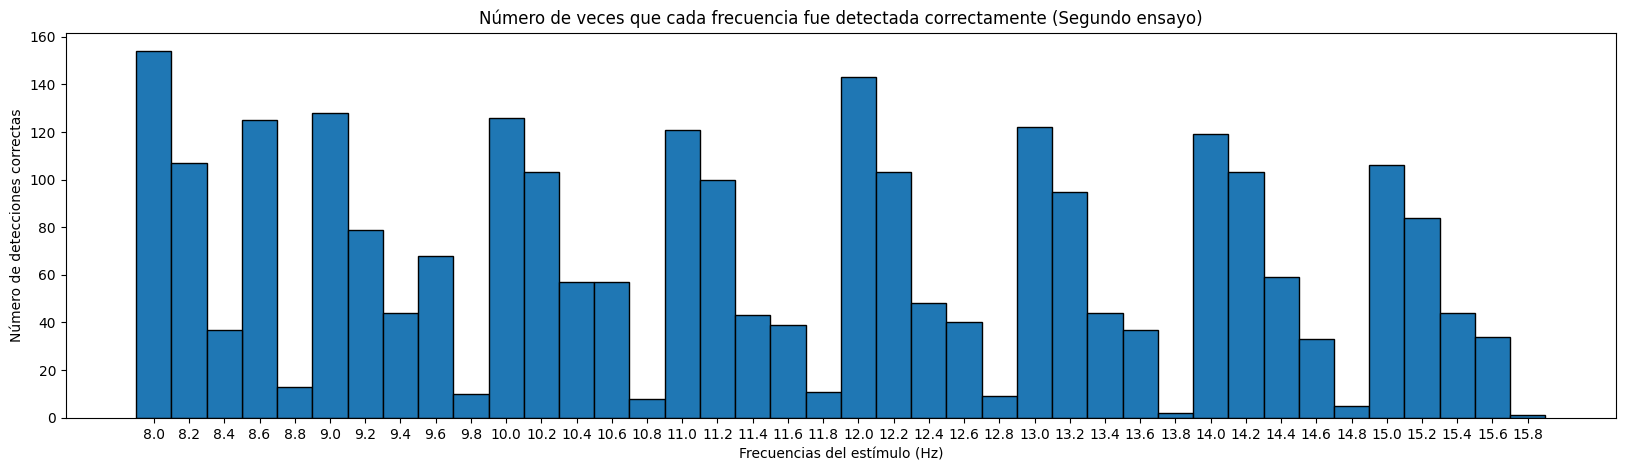

In [14]:
# Creamos la figura para el gráfico de barras
# El tamaño (20,5) permite visualizar bien todas las frecuencias a lo largo del eje x
plt.figure(figsize=(20, 5))

# Dibujamos las barras: en el eje x colocamos las frecuencias del estímulo (data_frequencies)
# En el eje y, el número de veces que cada frecuencia fue correctamente detectada (freqs_bars)
# Usamos barras estrechas (width=0.2) y borde negro para claridad visual
plt.bar(frecuencias_estimulo, conteo_frecuencias, width=0.2, edgecolor="black")

# Etiqueta del eje x
plt.xlabel('Frecuencias del estímulo (Hz)')

# Mostramos cada frecuencia como etiqueta del eje x
plt.xticks(frecuencias_estimulo)

# Etiqueta del eje y
plt.ylabel('Número de detecciones correctas')

# Título del gráfico
plt.title('Número de veces que cada frecuencia fue detectada correctamente (Segundo ensayo)')

# Mostramos el gráfico
plt.show()


Esta es una **vista en forma de tabla** de las frecuencias detectadas en cada ensayo.

Lo que hacemos es lo siguiente:

- Coloreamos en **rojo** aquellas frecuencias que **no fueron detectadas**, y las marcamos con un **0**.
- Coloreamos en **verde** aquellas que **sí fueron detectadas**, y las marcamos con un **1**.

Este formato permite identificar visualmente, ensayo por ensayo, cuáles frecuencias de estímulo fueron correctamente reconocidas por el sujeto en análisis.


In [16]:
# Creamos un DataFrame a partir de la matriz `result` (forma: 4 ensayos x 40 frecuencias)
# Las filas corresponden a los ensayos (T1–T4) y las columnas a las frecuencias de estímulo
df_ensayos = pd.DataFrame(matriz_resultado, index=["T1", "T2", "T3", "T4"], columns=frecuencias_estimulo)

# Aplicamos formato condicional con colores usando una función auxiliar del módulo utils
# Esta función colorea en verde los valores igual a 1 (frecuencia detectada)
# y en rojo los valores igual a 0 (frecuencia no detectada)
df_coloreado = df_ensayos.style.applymap(utils.colorear_valores_booleanos)

# Formateamos los valores como enteros (sin decimales)
df_formateado = df_coloreado.format(formatter="{:.0f}")

# Mostramos la tabla estilizada
display(df_formateado)


C:\Users\javie\AppData\Local\Temp\ipykernel_34920\1933360402.py:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_ensayos.style.applymap(utils.colorear_valores_booleanos)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
T2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
T4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Estos son los mismos datos representados en **formato de lista**.

Este formato puede ser útil si queremos trabajar directamente con los valores para procesamiento posterior o para exportarlos de forma más sencilla.


In [17]:
# Recorremos los 4 ensayos (índices 0 a 3)
for idx_ensayo in range(4):
    
    frecs_detectadas = []      # Lista para guardar las frecuencias detectadas en este ensayo
    frecs_no_detectadas = []  # Lista para guardar las frecuencias no detectadas en este ensayo

    # Recorremos las 40 frecuencias de estímulo
    for idx_frec in range(40):

        # Verificamos si esa frecuencia fue detectada (1) o no (0) en el resultado binario
        if matriz_resultado[idx_ensayo][idx_frec] == 1:
            frecs_detectadas.append(frecuencias_estimulo[idx_frec])       # Añadimos la frecuencia a la lista de detectadas
        else:
            frecs_no_detectadas.append(frecuencias_estimulo[idx_frec])   # Añadimos la frecuencia a la lista de no detectadas

    # Imprimimos el resultado para este ensayo
    print("---")
    print("Ensayo", idx_ensayo + 1, ":")
    print("Frecuencias detectadas: ", frecs_detectadas)
    print("Frecuencias no detectadas: ", frecs_no_detectadas)

---
Ensayo 1 :
Frecuencias detectadas:  [11.0, 11.2, 14.200000000000001]
Frecuencias no detectadas:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
---
Ensayo 2 :
Frecuencias detectadas:  [12.2]
Frecuencias no detectadas:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.4, 12.600000000000001, 12.8, 13.0, 13.200000000000001, 13.4, 13.600000000000001, 13.8, 14.0, 14.200000000000001, 14.4, 14.600000000000001, 14.8, 15.0, 15.200000000000001, 15.4, 15.600000000000001, 15.8, 8.0, 8.2, 8.4]
---
Ensayo 3 :
Frecuencias detectadas:  [12.0]
Frecuencias no detectadas:  [8.6, 8.799999999999999, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.

# CCA

Ahora vamos a realizar el análisis mediante **CCA (Canonical Correlation Analysis)** para obtener una perspectiva diferente utilizando un enfoque más sofisticado.

Este método permite evaluar la **correlación entre la señal EEG** y **señales de referencia sinusoidales** generadas a partir de las frecuencias de estímulo. CCA es especialmente útil para la detección de SSVEP, ya que tiene en cuenta múltiples armónicos y relaciones lineales multivariadas entre canales.


In [18]:
# Función que aplica Análisis de Correlación Canónica (CCA) para encontrar la frecuencia
# de estímulo cuya señal de referencia se correlaciona más con la señal EEG de entrada.
def detectar_frecuencia_cca(senal_eeg, señales_referencia, lista_frecuencias):
    
    # Inicializamos el modelo CCA con un único componente (el más significativo)
    modelo_cca = CCA(n_components=1)

    # Inicializamos el valor máximo de correlación y su frecuencia correspondiente
    mejor_correlacion = -np.inf
    indice_frecuencia_maxima = None

    # Recorremos todas las señales de referencia (una por cada frecuencia de estímulo)
    for idx, conjunto_ref in enumerate(señales_referencia):

        # Convertimos la señal de referencia a array y la reestructuramos en forma (N, 12)
        # Se asume que hay 6 senos y 6 cosenos para los 6 primeros armónicos
        X = np.array(conjunto_ref).reshape(-1, 12)

        # Transponemos la señal EEG para que tenga forma (N, canales)
        Y = senal_eeg.T

        # Ajustamos el modelo CCA con las señales de referencia (X) y EEG (Y)
        modelo_cca.fit(X, Y)

        # Proyectamos ambas señales al espacio canónico
        x_proy, y_proy = modelo_cca.transform(X, Y)

        # Calculamos la correlación lineal entre las dos primeras componentes canónicas
        correlacion_actual = np.corrcoef(x_proy[:, 0], y_proy[:, 0])[0, 1]

        # Si esta correlación es la mayor encontrada hasta el momento, la guardamos
        if correlacion_actual > mejor_correlacion:
            mejor_correlacion = correlacion_actual
            indice_frecuencia_maxima = idx  # Guardamos el índice de frecuencia

    # Devolvemos la frecuencia correspondiente a la correlación más alta, y el valor de dicha correlación
    return lista_frecuencias[indice_frecuencia_maxima], mejor_correlacion


In [19]:
# Índice del electrodo a analizar: Oz (canal 61)
canal_objetivo = 61

# Inicializamos un array para guardar los resultados de CCA
# Forma: (70 sujetos, 4 ensayos, 40 frecuencias de estímulo)
# Inicializamos con -1 como valor por defecto (indicando sin detección)
resultados_cca = np.full((70, 4, 40), -1.0)

# Recorremos los 70 sujetos del conjunto BETA
for idx_sujeto in range(1, 71):
    
    # Cargamos los datos EEG completos del sujeto
    senal_eeg, senal_eeg_estimulo, duracion_ensayo = utils.load_ssvep_data("Database BETA/", idx_sujeto)

    # Calculamos la duración de la señal por ensayo (número de muestras / tasa de muestreo)
    duracion = senal_eeg.shape[1] / fs

    # Generamos las señales de referencia senoidales y cosenoidales (6 armónicos) para todas las frecuencias
    señales_ref = []
    for k in range(40):
        # Generamos señal de referencia para la frecuencia i
        ref = np.array(utils.construir_senal_referencia(frecuencias_estimulo[k], fs, duracion, 6, 0))
        señales_ref.append(ref)
    
    # Convertimos a array de NumPy (shape: 40 x muestras x 12 señales de referencia)
    señales_ref = np.array(señales_ref)

    # Recorremos los 4 ensayos
    for idx_ensayo in range(4):

        # Recorremos las 40 condiciones de frecuencia
        for idx_frec in range(40):

            # Aplicamos filtro paso banda a la señal EEG correspondiente a Oz
            senal_filtrada = signal.lfilter(coef_b, coef_a, senal_eeg[canal_objetivo, :, idx_ensayo, idx_frec])

            # Aplicamos CCA para predecir la frecuencia más correlacionada con la señal EEG filtrada
            frecuencia_predicha, _ = detectar_frecuencia_cca(senal_filtrada, señales_ref, frecuencias_estimulo)

            # Guardamos la frecuencia detectada en la matriz de resultados
            resultados_cca[idx_sujeto - 1, idx_ensayo, idx_frec] = frecuencia_predicha



In [20]:
# Creamos una tabla para almacenar los resultados de CCA:
# 70 filas (una por sujeto) y 5 columnas:
# Las primeras 4 columnas corresponden a los 4 ensayos,
# y la última columna almacena la mejor precisión global (máxima entre los 4 ensayos)
tabla_cca = np.zeros((70, 5))

# Recorremos los 70 sujetos (índices 0 a 69)
for idx_sujeto in range(70):

    # Recorremos los 4 ensayos
    for idx_ensayo in range(4):

        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):

            # Si la frecuencia predicha por CCA coincide con la frecuencia real del estímulo,
            # consideramos que ha sido detectada correctamente
            if resultados_cca[idx_sujeto, idx_ensayo, idx_frec] == frecuencias_estimulo[idx_frec]:
                tabla_cca[idx_sujeto, idx_ensayo] += 1  # Sumamos un acierto en este ensayo

    # Convertimos el número de aciertos en porcentaje para cada ensayo
    tabla_cca[idx_sujeto, 0] = tabla_cca[idx_sujeto, 0] * 100 / 40  # Ensayo 1
    tabla_cca[idx_sujeto, 1] = tabla_cca[idx_sujeto, 1] * 100 / 40  # Ensayo 2
    tabla_cca[idx_sujeto, 2] = tabla_cca[idx_sujeto, 2] * 100 / 40  # Ensayo 3
    tabla_cca[idx_sujeto, 3] = tabla_cca[idx_sujeto, 3] * 100 / 40  # Ensayo 4

    # Guardamos el mejor resultado entre los cuatro ensayos en la columna "MAX"
    tabla_cca[idx_sujeto, 4] = max(
        max(tabla_cca[idx_sujeto, 0], tabla_cca[idx_sujeto, 1]),
        max(tabla_cca[idx_sujeto, 2], tabla_cca[idx_sujeto, 3])
    )


Aplicamos diferentes colores para facilitar la visualización de los **sujetos con mejor y peor rendimiento** en la detección utilizando CCA. El código de colores es el siguiente:

- 🔵 **Azul**: detección del **100 %**
- 🟢 **Verde**: detección **mayor al 75 %**
- 🟡 **Amarillo**: detección **mayor al 50 %**
- 🟠 **Naranja**: detección **mayor al 25 %**
- 🔴 **Rojo**: detección **igual o inferior al 25 %**

Este formato nos permite identificar rápidamente qué sujetos responden mejor a los estímulos y en qué medida lo hacen.


In [21]:
# Función que asigna un color según el porcentaje de detección
# Se usa para aplicar formato condicional en la tabla de resultados CCA
def colorear_cca(valor):
    if valor == 100:
        return 'color: blue'     # Detección perfecta
    elif valor >= 75:
        return 'color: green'    # Alto rendimiento
    elif valor >= 50:
        return 'color: yellow'   # Rendimiento aceptable
    elif valor >= 25:
        return 'color: orange'   # Bajo rendimiento
    else:
        return 'color: red'      # Muy bajo rendimiento

# Creamos una lista con los nombres de los sujetos para usar como índice en el DataFrame
nombres_filas = []
for i in range(70):
    nombres_filas.append("Subject " + str(i + 1))  # Ejemplo: "Subject 1", ..., "Subject 70"

# Creamos un DataFrame con los resultados de precisión de CCA
# Columnas: precisión por ensayo (T1–T4) y la mejor precisión global (MAX)
df_cca = pd.DataFrame(tabla_cca, index=nombres_filas, columns=["T1", "T2", "T3", "T4", "MAX"])

# Aplicamos formato condicional: cada celda se colorea según la función `color_cca`
df_cca_coloreado = df_cca.style.applymap(colorear_cca)

# Formateamos los valores para que se muestren como enteros sin decimales
df_cca_formateado = df_cca_coloreado.format(formatter="{:.0f}")

# Mostramos la tabla estilizada en pantalla
display(df_cca_formateado)

C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2414783408.py:25: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_cca_coloreado = df_cca.style.applymap(colorear_cca)


,T1,T2,T3,T4,MAX
Subject 1,82,82,85,98,98
Subject 2,30,28,15,28,30
Subject 3,90,80,85,88,90
Subject 4,22,22,30,22,30
Subject 5,25,15,15,10,25
Subject 6,48,30,32,35,48
Subject 7,15,22,25,18,25
Subject 8,42,40,42,58,58
Subject 9,82,82,72,72,82
Subject 10,60,72,68,55,72


# Ventanas deslizantes

In [22]:
# Definimos la longitud de la ventana deslizante
# 750 es el número de muestras correspondiente a un ensayo de 3 segundos con fs = 250 Hz (3 * 250 = 750)
# Se divide entre 3 para obtener una ventana que cubra aproximadamente 1 segundo
tamano_ventana = int(750 / 3)  # Longitud de la ventana (en muestras)

# Definimos el paso con el que se moverá la ventana
# Cuanto menor sea este paso, mayor será el solapamiento entre ventanas
salto_ventana = 10  # Número de muestras que se avanza en cada paso

# Mostramos por pantalla la configuración seleccionada
print("Longitud de la ventana =", tamano_ventana)
print("Paso de la ventana =", salto_ventana)

# Mostramos cuántas ventanas se obtendrían para un ensayo de 750 muestras (3 s)
# y para uno más largo de 1000 muestras (4 s), ambos con el mismo paso
print("Número de ventanas (ensayo de 3 s) =", len(np.arange(0, 750, step=salto_ventana)))
print("Número de ventanas (ensayo de 4 s) =", len(np.arange(0, 1000, step=salto_ventana)))

Longitud de la ventana = 250
Paso de la ventana = 10
Número de ventanas (ensayo de 3 s) = 75
Número de ventanas (ensayo de 4 s) = 100


In [23]:
# Creamos un array con los valores de ITR (Information Transfer Rate) proporcionados en el artículo
# Cada valor representa el ITR alcanzado por un sujeto en bits por minuto (bpm)

# El orden de los valores corresponde a los 70 sujetos del estudio (Subject 1 al Subject 70)
itr_por_sujeto = [
    139.63, 148.49, 143.02, 98.37, 134.44, 85.97, 120.77, 87.48, 132.28, 77.22,
     32.30, 136.97, 125.03, 103.00, 131.44, 94.84, 54.38, 182.66, 116.83, 73.09, 
    136.39, 122.74, 192.63, 109.57, 105.62, 84.67, 120.75, 116.35, 109.42, 117.79, 
     64.19, 72.39, 61.61, 128.43, 120.96, 131.44, 148.84, 72.80, 100.83, 87.37, 
     38.64, 132.80, 82.46, 46.05, 94.24, 84.49, 58.15, 144.17, 180.56, 75.67, 
     99.62, 136.78, 78.14, 86.02, 33.68, 138.09, 132.46, 113.79, 54.76, 111.07, 
     48.94, 89.35, 163.57, 81.16, 56.19, 150.49, 207.16, 117.60, 112.14, 123.50
]


## PSDA Modificado con Ventanas Deslizantes

Aquí incluimos el código necesario para aplicar nuestro método **PSDA modificado** utilizando un enfoque de **ventanas deslizantes**, con el objetivo de determinar **en qué momentos del ensayo** el método es capaz de detectar correctamente la frecuencia del estímulo.

Este análisis temporal nos permite observar no solo si se detecta correctamente la frecuencia, sino **cuándo** ocurre esa detección dentro del ensayo, lo cual es clave para evaluar el rendimiento del sistema en aplicaciones en tiempo real.


In [24]:
# Índice del electrodo que se va a analizar: Oz
canal_oz = 61

# Inicializamos un array para almacenar la posición (en muestras) donde se detecta el estímulo
# Forma: (70 sujetos, 4 ensayos, 40 frecuencias)
# Se inicializa con -1 para indicar que no se ha detectado
det_ej_deslizante_psda_mod = np.full((70, 4, 40), -1.0)

# Recorremos los 70 sujetos del conjunto de datos
for idx_sujeto in range(1, 71):
    
    # Cargamos los datos EEG completos del sujeto
    registros, registros_estimulo, duracion = utils.load_ssvep_data("Database BETA/", idx_sujeto)

    # Longitud máxima de un ensayo (número de muestras)
    longitud_maxima = len(registros[canal_oz, :, 0, 0])

    # Recorremos los 4 ensayos por frecuencia
    for idx_ensayo in range(4):

        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):

            detectado = False  # Variable de control para parar cuando se detecte correctamente

            # Establecemos el inicio y fin de la ventana deslizante
            # Saltamos los primeros 0,5 s (sin estímulo)
            inicio = int(fs * 0.5)
            fin = inicio + tamano_ventana

            # Aplicamos un primer filtrado a toda la señal (opcional, puede eliminarse)
            senal_filtrada = signal.lfilter(coef_b, coef_a, registros[canal_oz, :, idx_ensayo, idx_frec])
            fft_resultado = np.fft.fft(senal_filtrada)
            frecuencias = np.fft.fftfreq(len(senal_filtrada), d=1/fs)
            espectro = np.abs(fft_resultado) ** 2
            pico_inicial = np.abs(frecuencias[np.argmax(espectro)])  # (No se usa en esta implementación)

            paso = 0  # Contador de ventanas

            # Aplicamos el análisis ventana a ventana hasta detectar o llegar al final
            while not detectado and fin < longitud_maxima:

                # Extraemos la ventana de señal y aplicamos el filtro
                ventana_filtrada = signal.lfilter(coef_b, coef_a, registros[canal_oz, inicio:fin, idx_ensayo, idx_frec])

                # Calculamos la FFT y el espectro de potencia de la ventana actual
                fft_resultado = np.fft.fft(ventana_filtrada)
                frecuencias = np.fft.fftfreq(len(ventana_filtrada), d=1/fs)
                espectro = np.abs(fft_resultado) ** 2

                # Obtenemos la frecuencia correspondiente al pico del espectro
                pico_actual = np.abs(frecuencias[np.argmax(espectro)])

                # Buscamos la frecuencia del estímulo más cercana al pico detectado
                frecuencia_detectada = 0
                modulo_min = 1e5
                for i in range(40):
                    if pico_actual % frecuencias_estimulo[i] < modulo_min:
                        frecuencia_detectada = frecuencias_estimulo[i]
                        modulo_min = pico_actual % frecuencia_detectada

                # Si la frecuencia detectada coincide con la frecuencia real del estímulo:
                # marcamos como detectado y guardamos la posición inicial de la ventana
                if frecuencia_detectada == frecuencias_estimulo[idx_frec]:
                    detectado = True
                    det_ej_deslizante_psda_mod[idx_sujeto - 1, idx_ensayo, idx_frec] = inicio

                # Avanzamos la ventana según el paso definido
                inicio += salto_ventana
                fin += salto_ventana
                paso += 1

La ejecución de los códigos con **ventanas deslizantes** lleva cierto tiempo, especialmente en el caso del enfoque basado en **CCA**.

Para facilitar la visualización y el análisis posterior de los resultados, hemos creado funciones para **guardar y cargar los datos**. De este modo, podemos almacenar los resultados generados en archivos separados y cargarlos únicamente cuando los necesitemos, evitando volver a ejecutar todo el análisis.


In [39]:
# Guardamos los resultados del análisis PSDA modificado con ventanas deslizantes en un archivo
# Usamos la función guardar_datos del módulo utils para facilitar el proceso

# El primer argumento es la ruta donde se guardará el archivo (en formato HDF5)
# El segundo argumento es el array de resultados a guardar: sliding_detections_m_psda

utils.guardar_datos("Datos Guardados/psda_m_deslizante.h5", det_ej_deslizante_psda_mod)

Datos guardados correctamente en Datos Guardados/psda_m_deslizante.h5


In [27]:
# Función de formato condicional para colorear las celdas de la tabla
# Si el valor es distinto de -1, significa que se detectó la frecuencia, se colorea en verde
# Si el valor es -1, significa que no se detectó nunca, se colorea en rojo
def colorear_detecciones(val):
    if val != -1:
        return 'color: green'  # Detección realizada en alguna ventana
    else:
        return 'color: red'    # No se detectó en todo el ensayo

# Creamos un DataFrame con los datos de detección por ventana para el sujeto 55 (índice 54)
# Cada fila representa un ensayo (T1–T4) y cada columna una frecuencia de estímulo
df_detecciones_sujeto = pd.DataFrame(det_ej_deslizante_psda_mod[54, :, :], index=["T1", "T2", "T3", "T4"], columns=frecuencias_estimulo)

# Aplicamos formato condicional: celdas en verde si se detectó, en rojo si no
df_coloreado = df_detecciones_sujeto.style.applymap(colorear_detecciones)

# Formateamos los valores como enteros sin decimales (las detecciones son posiciones en muestras)
df_formateado = df_coloreado.format(formatter="{:.0f}")

# Mostramos la tabla estilizada
display(df_formateado)



C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3149739254.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_detecciones_sujeto.style.applymap(colorear_detecciones)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,125,-1,125,-1,-1,-1,-1,205,-1,-1,-1,-1,125,-1,595,-1,-1,175,-1,-1,495,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,545,-1,-1,505,-1,-1
T2,315,-1,295,-1,-1,-1,-1,125,-1,-1,-1,-1,135,-1,-1,-1,-1,225,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,545,-1,-1,-1,-1,275,-1,-1
T3,135,-1,215,-1,-1,-1,-1,185,-1,-1,-1,-1,125,-1,-1,-1,-1,365,-1,-1,-1,-1,145,-1,-1,-1,-1,435,-1,-1,-1,-1,685,-1,-1,-1,-1,145,-1,515
T4,185,-1,155,-1,-1,-1,-1,295,-1,-1,-1,-1,125,-1,-1,-1,-1,345,-1,-1,-1,-1,-1,-1,-1,-1,-1,615,-1,-1,-1,-1,175,-1,-1,-1,-1,215,-1,-1


In [28]:
# Creamos una tabla para almacenar los resultados de PSDA modificado con ventanas deslizantes
# Columnas:
# - [0]: Tiempo promedio de detección (en segundos)
# - [1]: Precisión (% de frecuencias detectadas sobre el total de 160)
# - [2]: ITR del sujeto (proporcionado previamente en subjects_ITR)
tabla_resumen_psda_deslizante = np.zeros((70, 3))  # 70 sujetos

# Recorremos los 70 sujetos
for idx_sujeto in range(70):
    tiempo_total = 0       # Acumulador del tiempo total de detección (en segundos)
    conteo_aciertos = 0    # Contador de detecciones correctas

    # Recorremos los 4 ensayos
    for idx_ensayo in range(4):

        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):

            # Si la frecuencia fue detectada (valor diferente de -1)
            if det_ej_deslizante_psda_mod[idx_sujeto, idx_ensayo, idx_frec] != -1:
                # Sumamos el tiempo (posición de la ventana en muestras / fs)
                tiempo_total += det_ej_deslizante_psda_mod[idx_sujeto, idx_ensayo, idx_frec] / fs
                conteo_aciertos += 1  # Contamos una detección

            # El bloque comentado se podría usar para penalizar no detecciones con un tiempo artificial

    # Guardamos el tiempo promedio de detección entre todas las detecciones realizadas
    tabla_resumen_psda_deslizante[idx_sujeto, 0] = tiempo_total / conteo_aciertos if conteo_aciertos != 0 else np.nan

    # Calculamos la precisión en porcentaje: detecciones / total de frecuencias (4 ensayos × 40)
    tabla_resumen_psda_deslizante[idx_sujeto, 1] = conteo_aciertos * 100 / 160

    # Añadimos el ITR correspondiente a ese sujeto desde la lista original
    tabla_resumen_psda_deslizante[idx_sujeto, 2] = itr_por_sujeto[idx_sujeto]



In [29]:
# Función para aplicar formato condicional según un umbral de valor
def aplicar_color_por_umbral(valor, umbral, color_si_supera, color_si_no):
    if valor >= umbral:
        return 'color: ' + color_si_supera
    else:
        return 'color: ' + color_si_no


In [30]:
# Creamos un DataFrame con los resultados para los 70 sujetos
df_deslizante = pd.DataFrame(
    tabla_resumen_psda_deslizante,
    index=range(1, 71),
    columns=["Tiempo promedio (s)", "Precisión (%)", "ITR"]
)

# Aplicamos formato condicional por columnas:

# 1. Tiempo promedio: rojo si >= 10 s (detección tardía), verde si < 10 s
df_coloreado = df_deslizante.style.applymap(lambda x: aplicar_color_por_umbral(x, 10, 'red', 'green'), subset=['Tiempo promedio (s)'])

# 2. Precisión: verde si >= 20 %, rojo si < 20 %
df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])

# 3. ITR: verde si >= 100, rojo si < 100
df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 100, 'green', 'red'), subset=['ITR'])

# Formateamos todos los valores con dos decimales
df_formateado = df_coloreado.format(formatter="{:.2f}")

# Mostramos la tabla estilizada
display(df_formateado)



C:\Users\javie\AppData\Local\Temp\ipykernel_34920\4160163794.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_deslizante.style.applymap(lambda x: aplicar_color_por_umbral(x, 10, 'red', 'green'), subset=['Tiempo promedio (s)'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\4160163794.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\4160163794.py:17: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 100, 'green', 'red'), subset=['ITR'])


,Tiempo promedio (s),Precisión (%),ITR
1,0.63,31.88,139.63
2,0.96,26.88,148.49
3,0.70,30.62,143.02
4,0.90,16.25,98.37
5,1.03,16.25,134.44
6,0.93,26.88,85.97
7,0.94,18.75,120.77
8,0.84,23.12,87.48
9,0.69,25.00,132.28
10,0.69,24.38,77.22


In [31]:
# Parámetros para el cálculo del ITR personalizado:
T_descanso = 0.55  # Tiempo fijo del periodo de descanso (en segundos)
num_clases = 40    # Número de clases posibles (frecuencias de estímulo)

# Lista para almacenar el ITR calculado para cada sujeto
itr_calculado_deslizante = []

# Recorremos los 70 sujetos
for idx_sujeto in range(70):

    # Obtenemos la precisión (entre 0 y 1) y el tiempo promedio de detección del sujeto
    precision = tabla_resumen_psda_deslizante[idx_sujeto, 1] / 100
    tiempo_medio = tabla_resumen_psda_deslizante[idx_sujeto, 0]

    # Evitamos problemas computacionales cuando P = 1 (log(1) = 0 pero log(0) es indefinido)
    if precision == 1:
        precision = 0.999999999

    # Fórmula del ITR (bits por minuto), considerando tiempo total = T + t
    itr = 60 * (
        np.log(num_clases) +
        precision * np.log(precision) +
        (1 - precision) * np.log((1 - precision) / (num_clases - 1))
    ) / (T_descanso + tiempo_medio)

    # Guardamos el valor calculado
    itr_calculado_deslizante.append(itr)


In [32]:
# Combinamos las métricas anteriores con el nuevo ITR personalizado
# La forma final de la tabla será: (70, 4) → Tiempo promedio, Precisión, ITR del artículo, ITR calculado
tabla_final_psda_deslizante = np.hstack((tabla_resumen_psda_deslizante, np.array(itr_calculado_deslizante)[:, np.newaxis]))


In [33]:
# Creamos el DataFrame con las métricas de cada sujeto
df_metricas_sujetos = pd.DataFrame(
    tabla_final_psda_deslizante,
    index=range(1, 71),
    columns=["Tiempo promedio", "Precisión (%)", "ITR del artículo", "Mi ITR"]
)

In [34]:
# Aplicamos formato condicional por columnas para facilitar la interpretación visual

# Verde si < 1s (detección rápida), rojo si ≥ 1s
df_coloreado = df_metricas_sujetos.style.applymap(lambda x: aplicar_color_por_umbral(x, 1, 'red', 'green'), subset=['Tiempo promedio'])

# Verde si precisión ≥ 20 %, rojo si menor
df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])

# Verde si ITR ≥ 100 bits/min, rojo si menor
df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 100, 'green', 'red'), subset=['ITR del artículo'])
df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 100, 'green', 'red'), subset=['Mi ITR'])

# Formateamos todos los valores con dos decimales
df_formateado = df_coloreado.format(formatter="{:.2f}")

# Mostramos la tabla final
display(df_formateado)

C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2169867155.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_metricas_sujetos.style.applymap(lambda x: aplicar_color_por_umbral(x, 1, 'red', 'green'), subset=['Tiempo promedio'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2169867155.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2169867155.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_coloreado.applymap(lambda x: aplicar_color_por_umbral(x, 100, 'green', 'red'), subset=['ITR del artículo'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\2169867155.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado = df_coloreado.applym

,Tiempo promedio,Precisión (%),ITR del artículo,Mi ITR
1,0.63,31.88,139.63,28.74
2,0.96,26.88,148.49,16.97
3,0.70,30.62,143.02,25.48
4,0.90,16.25,98.37,7.34
5,1.03,16.25,134.44,6.71
6,0.93,26.88,85.97,17.31
7,0.94,18.75,120.77,9.26
8,0.84,23.12,87.48,14.33
9,0.69,25.00,132.28,18.30
10,0.69,24.38,77.22,17.52


## CCA con ventanas deslizantes

Aquí incluimos el código para aplicar el método **CCA (Canonical Correlation Analysis)** utilizando un enfoque de **ventanas deslizantes**, con el objetivo de determinar **en qué momento del ensayo** se detecta correctamente la frecuencia del estímulo.

Este análisis nos permite evaluar la **respuesta temporal del sistema**, observando cuándo ocurre la detección a lo largo del tiempo, lo cual es esencial para aplicaciones BCI en tiempo real.


In [35]:
# Función que aplica Análisis de Correlación Canónica (CCA) para encontrar
# qué frecuencia de estímulo tiene mayor correlación con la señal EEG proporcionada.
def calcular_frecuencia_cca(senal, señales_referencia, frecuencias_estimulo):
    
    # Inicializamos el modelo de CCA con un único componente canónico
    modelo = CCA(n_components=1)

    # Inicializamos el valor máximo de correlación encontrado y su frecuencia asociada
    correlacion_maxima = -np.inf
    frecuencia_mas_correlacionada = None

    # Recorremos todas las señales de referencia (una por cada frecuencia de estímulo)
    for idx, conjunto_ref in enumerate(señales_referencia):

        # Convertimos la señal de referencia a array de NumPy y la reorganizamos
        # Se supone que contiene 6 senos y 6 cosenos → total 12 columnas (armónicos)
        X = np.array(conjunto_ref).reshape(-1, 12)

        # Transponemos la señal EEG si es necesario → forma (n_muestras, 1)
        Y = senal.T

        # Ajustamos el modelo CCA a los datos (X = señales referencia, Y = EEG)
        modelo.fit(X, Y)

        # Proyectamos ambas señales al espacio canónico
        proy_X, proy_Y = modelo.transform(X, Y)

        # Calculamos la correlación lineal entre las dos primeras componentes canónicas
        correlacion = np.corrcoef(proy_X[:, 0], proy_Y[:, 0])[0, 1]

        # Si esta correlación es la mayor encontrada hasta el momento, la guardamos
        if correlacion > correlacion_maxima:
            correlacion_maxima = correlacion
            frecuencia_mas_correlacionada = idx

    # Devolvemos la frecuencia correspondiente al mayor valor de correlación encontrado
    # y el valor de dicha correlación
    return frecuencias_estimulo[frecuencia_mas_correlacionada], correlacion_maxima


In [36]:
# Calculamos la duración temporal (en segundos) de la ventana deslizante
duracion_ventana = tamano_ventana / fs  # duración = número de muestras / frecuencia de muestreo

# Lista para almacenar las señales de referencia generadas para cada frecuencia de estímulo
referencias_generadas = []

# Recorremos las 40 frecuencias del conjunto de estímulos
for idx in range(40):
    
    # Generamos la señal de referencia para la frecuencia i
    # Incluye 6 armónicos (senos y cosenos), sin fase (fase = 0)
    ref = np.array(utils.construir_senal_referencia(
        frecuencias_estimulo[idx],  # Frecuencia de estímulo
        fs,                         # Frecuencia de muestreo
        duracion_ventana,           # Duración de la ventana (en segundos)
        6,                          # Número de armónicos
        0                           # Fase inicial
    ))
    
    # Añadimos la señal generada a la lista de referencias
    referencias_generadas.append(ref)

# Convertimos la lista a un array de NumPy para facilitar su uso posterior
# Dimensiones resultantes: (40, muestras, 12) → 40 frecuencias × n_muestras × 12 componentes (6 senos + 6 cosenos)
referencias_generadas = np.array(referencias_generadas)



In [37]:
# Inicializamos una matriz para guardar el instante (en muestras) donde se detecta la frecuencia correcta
# Dimensiones: 70 sujetos × 4 ensayos × 40 frecuencias
# Se inicializa con -1 para indicar que no hubo detección
detecciones_cca_deslizante = np.full((70, 4, 40), -1.0)

# Índice del electrodo que analizamos (Oz)
canal_objetivo = 61

# Recorremos los 70 sujetos del conjunto de datos
for idx_sujeto in range(1, 71):
    
    # Cargamos los datos EEG del sujeto actual
    registros_eeg, _, _ = utils.load_ssvep_data("Database BETA/", idx_sujeto)

    # Obtenemos la longitud del ensayo (número de muestras)
    longitud_ensayo = len(registros_eeg[canal_objetivo, :, 0, 0])

    # Recorremos los 4 ensayos disponibles para cada frecuencia
    for idx_ensayo in range(4):

        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):

            detectado = False  # Indicador de si se ha detectado correctamente la frecuencia

            # Saltamos los primeros 0,5 segundos (sin estímulo)
            inicio = int(fs * 0.5)
            fin = inicio + tamano_ventana  # Establecemos la primera ventana

            # Aplicamos un filtro paso banda a toda la señal del ensayo (opcional)
            senal_filtrada = signal.lfilter(coef_b, coef_a, registros_eeg[canal_objetivo, :, idx_ensayo, idx_frec])

            paso_actual = 0  # Contador de pasos de la ventana

            # Recorremos la señal usando ventanas deslizantes hasta que se detecte o se llegue al final
            while not detectado and fin < longitud_ensayo:

                # Aplicamos CCA a la ventana actual de la señal EEG
                frecuencia_predicha, _ = calcular_frecuencia_cca(
                    senal_filtrada[inicio:fin],    # Ventana EEG actual
                    referencias_generadas,         # Señales de referencia precomputadas
                    frecuencias_estimulo           # Lista de frecuencias reales
                )

                # Si la frecuencia predicha coincide con la real → detección correcta
                if frecuencia_predicha == frecuencias_estimulo[idx_frec]:
                    detectado = True
                    detecciones_cca_deslizante[idx_sujeto - 1, idx_ensayo, idx_frec] = inicio  # Guardamos la posición

                # Avanzamos la ventana
                inicio += salto_ventana
                fin += salto_ventana
                paso_actual += 1



In [38]:
# Guardamos los resultados del análisis CCA con ventanas deslizantes en un archivo .h5
# Esto permite cargar los resultados más adelante sin tener que volver a ejecutar el proceso completo

# Parámetros:
# - "Datos Guardados/sliding_cca.h5": ruta y nombre del archivo de destino
# - detecciones_cca_deslizante: array que contiene, para cada sujeto, ensayo y frecuencia,
#    la posición (en muestras) donde se detectó correctamente el estímulo (o -1 si no se detectó)

utils.guardar_datos("Datos Guardados/cca_deslizante.h5", detecciones_cca_deslizante)


Datos guardados correctamente en Datos Guardados/cca_deslizante.h5


In [40]:
# Función para aplicar formato condicional en la tabla:
# Si el valor es distinto de -1, significa que se detectó la frecuencia → verde
# Si el valor es -1, no se detectó en ninguna ventana → rojo
def marcar_deteccion(val):
    if val != -1:
        return 'color: green'
    else:
        return 'color: red'

# Creamos un DataFrame con los resultados del sujeto 18 (índice 17)
# Filas: los 4 ensayos (T1–T4)
# Columnas: las 40 frecuencias de estímulo
# Cada celda contiene la muestra donde se detectó la frecuencia (o -1 si no se detectó)
df_s18_cca = pd.DataFrame(
    detecciones_cca_deslizante[17, :, :],
    index=["T1", "T2", "T3", "T4"],
    columns=frecuencias_estimulo
)

# Aplicamos el formato condicional: celdas en verde si se detectó, rojo si no
df_coloreado_cca = df_s18_cca.style.applymap(marcar_deteccion)

# Mostramos los valores como enteros sin decimales
df_formateado_cca = df_coloreado_cca.format(formatter="{:.0f}")

# Visualizamos la tabla con los colores aplicados
display(df_formateado_cca)


C:\Users\javie\AppData\Local\Temp\ipykernel_34920\1862890159.py:21: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado_cca = df_s18_cca.style.applymap(marcar_deteccion)


,8.600000,8.800000,9.000000,9.200000,9.400000,9.600000,9.800000,10.000000,10.200000,10.400000,10.600000,10.800000,11.000000,11.200000,11.400000,11.600000,11.800000,12.000000,12.200000,12.400000,12.600000,12.800000,13.000000,13.200000,13.400000,13.600000,13.800000,14.000000,14.200000,14.400000,14.600000,14.800000,15.000000,15.200000,15.400000,15.600000,15.800000,8.000000,8.200000,8.400000
T1,255,125,125,175,125,125,125,175,165,125,275,185,185,125,195,145,155,145,125,285,155,135,125,215,125,135,175,145,235,185,145,165,185,135,125,145,-1,125,135,125
T2,155,255,135,135,125,225,185,165,125,165,125,285,165,155,145,135,135,155,175,125,125,275,145,135,125,175,145,135,145,125,175,125,125,165,205,125,205,135,145,125
T3,135,125,125,125,125,125,125,135,165,145,125,665,125,145,135,225,135,125,125,125,125,175,155,175,125,175,125,165,125,145,125,185,145,135,265,125,385,195,125,125
T4,145,215,125,125,165,255,125,125,125,155,145,145,185,135,125,175,125,145,135,165,185,165,155,275,175,155,145,255,265,125,155,205,385,255,175,205,195,135,155,145


In [41]:
# Creamos una matriz para almacenar los resultados de 3 métricas por sujeto:
# - [0]: Tiempo promedio de detección (en segundos)
# - [1]: Precisión (% de frecuencias detectadas)
# - [2]: ITR del artículo original (proporcionado previamente)
tabla_metricas_cca = np.zeros((70, 3))  # 70 sujetos

# Recorremos todos los sujetos
for idx_sujeto in range(70):
    tiempo_total = 0       # Acumulador del tiempo total de detección
    aciertos = 0           # Contador de frecuencias detectadas correctamente

    # Recorremos los 4 ensayos
    for idx_ensayo in range(4):
        # Recorremos las 40 frecuencias de estímulo
        for idx_frec in range(40):
            if detecciones_cca_deslizante[idx_sujeto, idx_ensayo, idx_frec] != -1:
                # Suma del instante de detección (convertido a segundos)
                tiempo_total += detecciones_cca_deslizante[idx_sujeto, idx_ensayo, idx_frec] / fs
                aciertos += 1  # Contamos una detección

            # Comentado: tiempo artificial si no hay detección

    # Calculamos el tiempo promedio por frecuencia detectada
    tabla_metricas_cca[idx_sujeto, 0] = tiempo_total / aciertos if aciertos > 0 else np.nan

    # Precisión: número de frecuencias detectadas / total (160)
    tabla_metricas_cca[idx_sujeto, 1] = aciertos * 100 / 160

    # ITR original extraído de la lista
    tabla_metricas_cca[idx_sujeto, 2] = itr_por_sujeto[idx_sujeto]


In [42]:
# Función para aplicar color condicional según un umbral
def aplicar_color_umbral(valor, umbral, color_si_cumple, color_si_falla):
    if valor >= umbral:
        return 'color: ' + color_si_cumple
    else:
        return 'color: ' + color_si_falla


In [43]:
# Creamos un DataFrame con las métricas obtenidas para todos los sujetos
df_resultados_cca = pd.DataFrame(
    tabla_metricas_cca,
    index=range(1, 71),
    columns=["Tiempo promedio", "Precisión (%)", "ITR"]
)


In [44]:
# Aplicamos estilo condicional para facilitar la lectura visual:

# Tiempo promedio: rojo si ≥ 10 s, verde si < 10 s
df_coloreado_cca = df_resultados_cca.style.applymap(lambda x: aplicar_color_umbral(x, 10, 'red', 'green'), subset=['Tiempo promedio'])

# Precisión: verde si ≥ 20 %, rojo si < 20 %
df_coloreado_cca = df_coloreado_cca.applymap(lambda x: aplicar_color_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])

# ITR: verde si ≥ 100, rojo si < 100
df_coloreado_cca = df_coloreado_cca.applymap(lambda x: aplicar_color_umbral(x, 100, 'green', 'red'), subset=['ITR'])

# Mostramos los valores con 2 decimales
df_formateado_cca = df_coloreado_cca.format(formatter="{:.2f}")

# Visualizamos la tabla final
display(df_formateado_cca)

C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3547593289.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado_cca = df_resultados_cca.style.applymap(lambda x: aplicar_color_umbral(x, 10, 'red', 'green'), subset=['Tiempo promedio'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3547593289.py:7: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado_cca = df_coloreado_cca.applymap(lambda x: aplicar_color_umbral(x, 20, 'green', 'red'), subset=['Precisión (%)'])
C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3547593289.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df_coloreado_cca = df_coloreado_cca.applymap(lambda x: aplicar_color_umbral(x, 100, 'green', 'red'), subset=['ITR'])


,Tiempo promedio,Precisión (%),ITR
1,0.64,96.88,139.63
2,0.92,66.25,148.49
3,0.64,97.50,143.02
4,1.02,75.62,98.37
5,1.11,58.75,134.44
6,0.95,63.12,85.97
7,1.14,55.62,120.77
8,0.89,78.75,87.48
9,0.68,96.88,132.28
10,0.76,97.50,77.22


# Señales de Referencia Sintéticas

En esta sección generamos las señales de referencia sintéticas que utilizamos para el análisis con CCA. Usamos las **mismas funciones de representación** que empleamos con nuestros datos reales, por lo que en las gráficas aparecerán etiquetas y áreas sombreadas aunque, en este caso, **no habrá sombreado** (ya que no hay datos experimentales).

Ajustando el siguiente código, generamos las señales sintéticas con **distinto número de armónicos** y sin variaciones en la frecuencia a lo largo del tiempo. A continuación, presentamos únicamente las señales generadas.


In [45]:
# Creamos un vector de tiempo para un ensayo completo
# 750 muestras / 250 Hz = 3 segundos
tiempo_ensayo = np.arange(0, 750 / fs, 1 / fs)

# Frecuencia fundamental de la señal sintética (en Hz)
frecuencia_central = 13

# Amplitud de la señal fundamental
amplitud = 4

# Número de armónicos que se van a generar (además del fundamental)
num_armonicos = 3

# Generamos la señal base oscilatoria (frecuencia fundamental)
senal_fundamental = amplitud * np.sin(2 * np.pi * frecuencia_central * tiempo_ensayo)

# Creamos una lista con las frecuencias de los armónicos
# Ejemplo: si f = 13 Hz y n_harmonics = 3 → [26, 39, 52]
frecuencias_armonicas = [frecuencia_central * k for k in range(2, 2 + num_armonicos)]

# Generamos las señales oscilatorias correspondientes a cada armónico
componentes_armonicos = [np.sin(2 * np.pi * f * tiempo_ensayo) for f in frecuencias_armonicas]

# Escalamos la amplitud de cada armónico: se reduce cuanto mayor es el orden
for idx in range(len(componentes_armonicos)):
    componentes_armonicos[idx] *= (amplitud / (idx + 2))

# Empezamos con la señal base como señal combinada
senal_compleja = np.copy(senal_fundamental)

# Insertamos fragmentos de los armónicos en posiciones aleatorias de la señal base
# Cada fragmento tiene una duración de 200 muestras (~0.8 s)
# Se añaden múltiples veces para simular contribuciones armónicas dispersas en el tiempo
for armonico in componentes_armonicos:
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]
    ini = random.randint(0, len(senal_compleja) - 200)
    senal_compleja[ini:ini + 200] += armonico[ini:ini + 200]

# Añadimos ruido blanco gaussiano a la señal combinada
# El valor noise_amplitude determina la intensidad del ruido
intensidad_ruido = 1
ruido_gaussiano = intensidad_ruido * np.random.randn(len(senal_compleja))

# Sumamos el ruido a la señal final
senal_sintetica_final = senal_compleja + ruido_gaussiano


c:\Users\javie\OneDrive\Escritorio\UAM\QUINTO\TFG INFO\CÓDIGO\utils.py:389: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


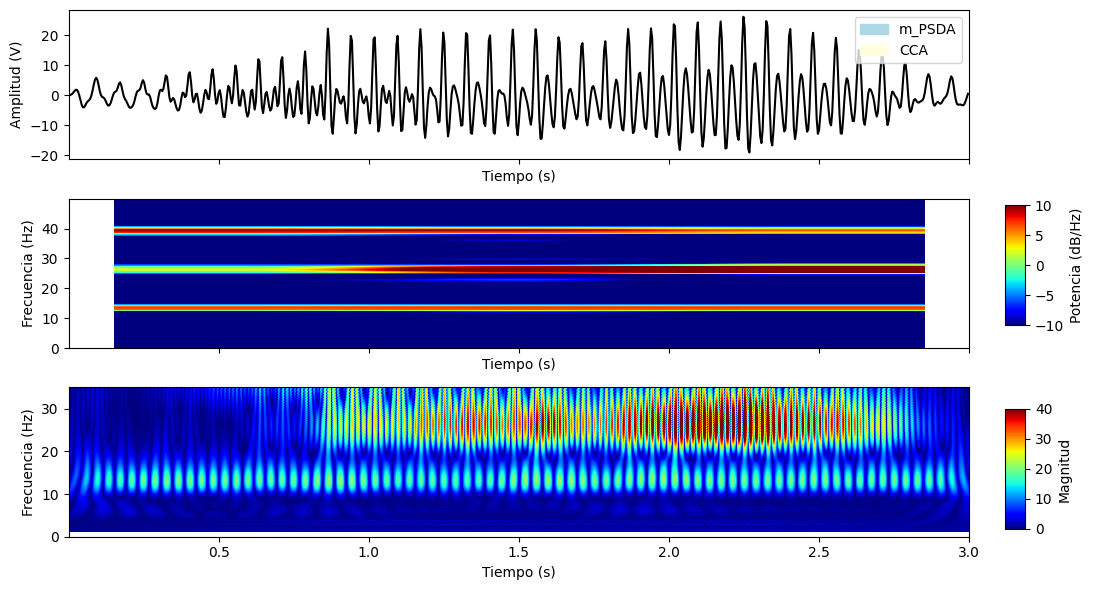

In [46]:
# Representamos la señal sintética ruidosa utilizando la función personalizada de visualización.
# La función `plot_generation_spectrogram_wavelet` muestra:
# - La forma de onda de la señal.
# - Su espectrograma de tiempo-frecuencia basado en wavelets.
# 
# Parámetros utilizados:
# - `senal_sintetica_final`: señal sintética generada con armónicos y ruido.
# - `fs`: frecuencia de muestreo (250 Hz).
# - `0`: valor inicial del tiempo (inicio del ensayo).
# - `[10]`: lista con frecuencias a resaltar visualmente (en este caso, 10 Hz).
# - `True`: habilita la visualización del espectrograma.
# - `False`: desactiva el sombreado de secciones sin estímulo.
# - `""`: título vacío.
# - `[-1, -1]`: sin marcas temporales específicas.
# - `0`: no se aplica desplazamiento en la señal.

utils.plot_generation_spectrogram_wavelet(senal_sintetica_final, fs, 0, [10], True, False, "", [-1, -1], 0)

In [47]:
# Creamos un vector de tiempo para un ensayo completo de 3 segundos
tiempo = np.arange(0, 750 / fs, 1 / fs)

# Parámetros iniciales (algunos no se usan en este ejemplo concreto)
frecuencia_base = 13
amplitud_base = 4
numero_armonicos = 3

# Frecuencias que se usarán por tramos de tiempo
frecuencia_tramo_1 = 8    # Frecuencia inicial y final
frecuencia_tramo_2 = 14   # Frecuencia intermedia

# Amplitud del ruido blanco
intensidad_ruido = 0.8

# Puntos de cambio de frecuencia (1/3 y 2/3 del ensayo)
punto_cambio_1 = int(len(tiempo) / 3)
punto_cambio_2 = int(2 * len(tiempo) / 3)

# Generamos tres tramos de señal senoidal con distintas frecuencias
tramo_1 = np.sin(2 * np.pi * frecuencia_tramo_1 * tiempo[:punto_cambio_1])  # Primer tercio (8 Hz)
tramo_2 = np.sin(2 * np.pi * frecuencia_tramo_2 * tiempo[punto_cambio_1:punto_cambio_2]) * 1.2  # Segundo tercio (14 Hz, mayor amplitud)
tramo_3 = np.sin(2 * np.pi * frecuencia_tramo_1 * tiempo[punto_cambio_2:])  # Último tercio (8 Hz)
tramo_4 = np.sin(2 * np.pi * frecuencia_tramo_2 * tiempo[punto_cambio_2:]) * 1.2  # Se mezcla también con 14 Hz

# (Opcional) Aplicamos ventanas de Hann para suavizar las transiciones
ventana_1 = np.hanning(2 * punto_cambio_1)[:punto_cambio_1]                              # Inicio suave
ventana_2 = np.hanning(punto_cambio_2 - punto_cambio_1)                                  # Intermedio suave
ventana_3 = np.hanning(2 * (len(tiempo) - punto_cambio_2))[-(len(tiempo) - punto_cambio_2):]  # Final suave

# Versión con transiciones suaves (comentada)
# senal_combinada = np.concatenate([
#     tramo_1 * ventana_1,
#     tramo_2 * ventana_2,
#     (tramo_3 + tramo_4) * ventana_3
# ])

# Versión con transición brusca pero combinando ambas señales al final
# Se multiplica por 5 para aumentar la amplitud total de la señal
senal_combinada = np.concatenate([tramo_1, tramo_2, tramo_3 + tramo_4]) * 5

# Añadimos ruido blanco gaussiano escalado
ruido = intensidad_ruido * np.random.normal(size=len(tiempo)) * 4

# Señal final ruidosa
senal_final_con_ruido = senal_combinada + ruido


C:\Users\javie\AppData\Local\Temp\ipykernel_34920\3733755050.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


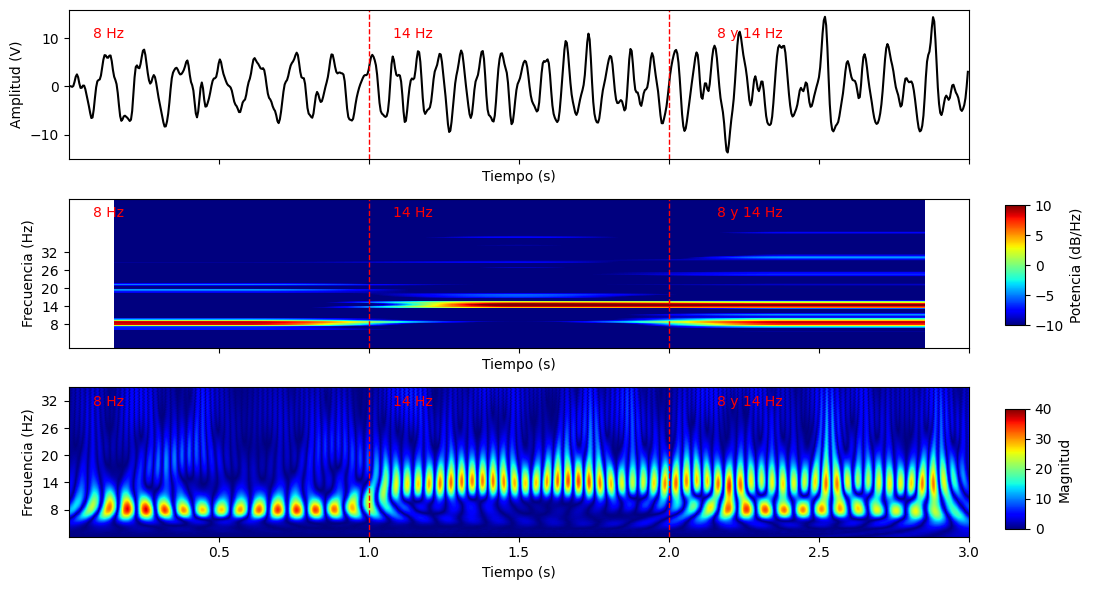

In [50]:
# Asignamos la señal ruidosa a una variable de nombre más representativo
senal_filtrada = senal_final_con_ruido

# Elegimos la wavelet Morlet para el análisis de tiempo-frecuencia
wavelet_utilizada = "morl"

# Parámetros del filtro paso banda (para eliminar componentes no deseadas)
frecuencia_baja = 5
frecuencia_alta = 40
fs = 250  # Frecuencia de muestreo en Hz

# Creamos un filtro de Butterworth de 4º orden y aplicamos el filtrado
b, a = signal.butter(4, [frecuencia_baja, frecuencia_alta], fs=fs, btype='band')
senal_filtrada_band = signal.lfilter(b, a, senal_filtrada)

# Rango de frecuencias a analizar con wavelets (de 1 a 40 Hz con paso 0,01)
# Se normaliza dividiendo por fs para convertir a escala
frecuencias_wavelet = np.arange(1, 40, 0.01) / fs

# Se convierten las frecuencias a escalas para la transformada wavelet
escalas = pywt.frequency2scale(wavelet_utilizada, frecuencias_wavelet)

# Aplicamos la transformada wavelet continua (CWT)
coeficientes_cwt, freqs_escalados = pywt.cwt(senal_filtrada_band, escalas, wavelet_utilizada)

# Volvemos a escalar las frecuencias a Hz
frecuencias_wavelet = frecuencias_wavelet * fs

# Creamos el vector de tiempo
eje_tiempo = np.arange(0, len(senal_filtrada) / fs, 1 / fs)

# Creamos una figura con 3 subgráficos:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 6), sharex=True)

# === PRIMER SUBGRÁFICO: Señal filtrada ===
ax1.plot(eje_tiempo, senal_filtrada_band, 'k')
ax1.set_xlim(0, 4)

if len(senal_filtrada) < 750:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax1.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])

ax1.set_xlim(0, len(senal_filtrada) / fs)
ax1.set_ylabel("Amplitud (V)")
ax1.set_xlabel("Tiempo (s)")

ax1.axvline(x=(punto_cambio_1 / fs), color='r', linestyle='--', linewidth=1)
ax1.axvline(x=(punto_cambio_2 / fs), color='r', linestyle='--', linewidth=1)
ax1.text(0 + 0.08, 10, f'{frecuencia_tramo_1} Hz', color='r', fontsize=10)
ax1.text((punto_cambio_1 / fs) + 0.08, 10, f'{frecuencia_tramo_2} Hz', color='r', fontsize=10)
ax1.text((punto_cambio_2 / fs) + 0.16, 10, '8 y 14 Hz', color='r', fontsize=10)

# === SEGUNDO SUBGRÁFICO: Espectrograma ===
ax2.axvline(x=(punto_cambio_1 / fs), color='r', linestyle='--', linewidth=1)
ax2.axvline(x=(punto_cambio_2 / fs), color='r', linestyle='--', linewidth=1)
ax2.text(0 + 0.08, 44, f'{frecuencia_tramo_1} Hz', color='r', fontsize=10)
ax2.text((punto_cambio_1 / fs) + 0.08, 44, f'{frecuencia_tramo_2} Hz', color='r', fontsize=10)
ax2.text((punto_cambio_2 / fs) + 0.16, 44, '8 y 14 Hz', color='r', fontsize=10)

vmin = -10
vmax = 10
Pxx, freqs_espectro, bins, im = ax2.specgram(
    senal_filtrada_band,
    NFFT=300,
    Fs=fs,
    noverlap=int(300 / 4),
    cmap='jet',
    vmin=vmin,
    vmax=vmax
)

ticks_frecuencia = [8, 14, 20, 26, 32]
ax2.set_yticks(ticks_frecuencia)

if len(senal_filtrada) < 750:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5])
else:
    ax2.set_xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5])

ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Frecuencia (Hz)')
ax2.set_ylim(0, 50)

cbar_ax2 = fig.add_axes([1.01, 0.45, 0.02, 0.2])
plt.colorbar(im, cax=cbar_ax2, label='Potencia (dB/Hz)')

# === TERCER SUBGRÁFICO: Wavelet ===
ax3.axvline(x=(punto_cambio_1 / fs), color='r', linestyle='--', linewidth=1)
ax3.axvline(x=(punto_cambio_2 / fs), color='r', linestyle='--', linewidth=1)
ax3.text(0 + 0.08, 31, f'{frecuencia_tramo_1} Hz', color='r', fontsize=10)
ax3.text((punto_cambio_1 / fs) + 0.08, 31, f'{frecuencia_tramo_2} Hz', color='r', fontsize=10)
ax3.text((punto_cambio_2 / fs) + 0.16, 31, '8 y 14 Hz', color='r', fontsize=10)

vmin = 0
vmax = 40
ax3.imshow(
    np.abs(coeficientes_cwt),
    aspect='auto',
    cmap='jet',
    extent=[0, len(senal_filtrada_band) / fs, frecuencias_wavelet[-1], frecuencias_wavelet[0]],
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Frecuencia (Hz)')
ax3.set_ylim(2, 35)
ax3.set_yticks(ticks_frecuencia)
ax3.set_xlim(0, len(senal_filtrada) / fs)

cbar_ax3 = fig.add_axes([1.01, 0.11, 0.02, 0.2])
plt.colorbar(ax3.images[0], cax=cbar_ax3, label="Magnitud")

# Ajustamos la disposición para evitar superposición
plt.tight_layout()



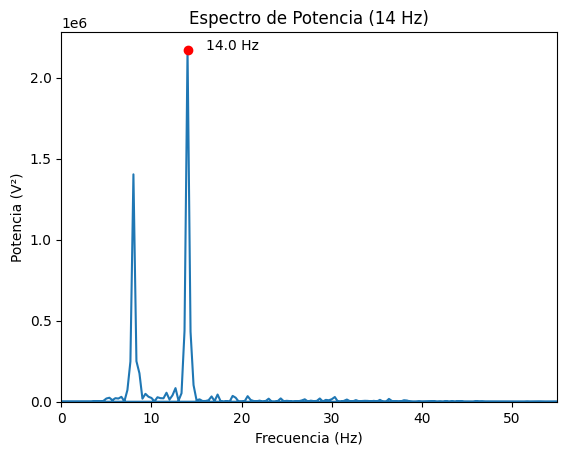

In [51]:
# Representamos el análisis en frecuencia de la señal utilizando la FFT (Transformada Rápida de Fourier)
# mediante la función personalizada `plot_generation_fft`.

# Parámetros:
# - `senal_filtrada`: señal de EEG (en este caso, una señal sintética) que queremos analizar.
# - `fs`: frecuencia de muestreo en Hz (normalmente 250).
# - `14`: frecuencia de referencia (por ejemplo, una frecuencia de interés que queremos marcar en el gráfico).
# - `True`: activa la visualización del espectro de frecuencias.
# - `False`: desactiva el sombreado de zonas sin estímulo (no aplicable aquí al ser una señal sintética).
# - `""`: sin título adicional en el gráfico.

# Esta función genera un gráfico que representa la potencia espectral de la señal en función de la frecuencia,
# permitiendo identificar si existen picos relevantes (por ejemplo, en 8 Hz y 14 Hz) como los insertados
# en la señal sintética que hemos generado antes.

utils.plot_generation_fft(senal_filtrada, fs, 14, True, False, "")